#Preparation

In [7]:
!pip install pystan
!pip install prophet

     |████████████████████████████████| 65 kB 2.4 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6639922 sha256=9d6c576a9b372e104e316181427ddedc1668832d7307a33dcf550884052ff22e
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [2]:
#this notebook was made in colab due to environment issues
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas import to_datetime
import datetime

In [4]:
bc = pd.read_csv('/content/drive/MyDrive/Binance-BC-EDA.csv')
bc

,Date,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,Ignore,Return,Day of Week
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,2017-08-17 23:59:59.999000064,3.454770e+06,3427,616.248541,2.678216e+06,8733.911395,NaN,Thu
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,2017-08-18 23:59:59.999000064,5.086958e+06,5233,972.868710,4.129123e+06,9384.141409,-0.041238,Fri
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,2017-08-19 23:59:59.999000064,1.549484e+06,2153,274.336042,1.118002e+06,9184.085529,0.007694,Sat
3,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,2017-08-20 23:59:59.999000064,1.930364e+06,2321,376.795947,1.557401e+06,10125.414084,-0.012969,Sun
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,2017-08-21 23:59:59.999000064,2.797232e+06,3972,557.356107,2.255663e+06,11706.769970,-0.017201,Mon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1593,2021-12-27,50775.48,52088.00,50449.00,50701.44,28779.582120,2021-12-27 23:59:59.999000064,1.471424e+09,1009238,14432.910350,7.382075e+08,0.000000,-0.001458,Mon
1594,2021-12-28,50701.44,50704.05,47313.01,47543.74,45853.339240,2021-12-28 23:59:59.999000064,2.242102e+09,1345774,21743.170130,1.063172e+09,0.000000,-0.062280,Tue
1595,2021-12-29,47543.74,48139.08,46096.99,46464.66,39498.870000,2021-12-29 23:59:59.999000064,1.873786e+09,1114074,19089.619100,9.059697e+08,0.000000,-0.022697,Wed
1596,2021-12-30,46464.66,47900.00,45900.00,47120.87,30352.295690,2021-12-30 23:59:59.999000064,1.428756e+09,910157,14886.523750,7.007923e+08,0.000000,0.014123,Thu


# Modeling

In [8]:
import prophet as Prophet
print('Prophet %s' % Prophet.__version__)

from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

Prophet 1.0


In [9]:
#limit the dataset to the date and closing price
bc_date_close = bc[['Date', 'Close']]
#rename to the required format for prophet
bc_date_close.columns = ['ds', 'y']
# define the model
model = Prophet.Prophet()
# fit the model on the entire dataset
model.fit(bc_date_close)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
#Make a dataframe for future predictions and specify the capacity in the future. 
#Predict next 30 after the final date
future = model.make_future_dataframe(periods=30,freq='D')
forecast = model.predict(future)

In [11]:
#View the predicted 30 days
forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]

,ds,yhat_lower,yhat_upper,yhat
0,2017-08-17,-254.295471,11038.088857,5550.841394
1,2017-08-18,-271.495482,10746.871362,5652.528120
2,2017-08-19,13.436222,10888.979496,5745.247452
3,2017-08-20,368.417763,11200.548686,5770.089819
4,2017-08-21,589.897569,11393.087734,5819.220677
...,...,...,...,...
1623,2022-01-26,50202.294258,60916.399524,55713.500985
1624,2022-01-27,50082.205021,60967.373364,55606.890228
1625,2022-01-28,50188.234084,60991.407093,55648.272781
1626,2022-01-29,49955.821942,61081.139313,55714.182794


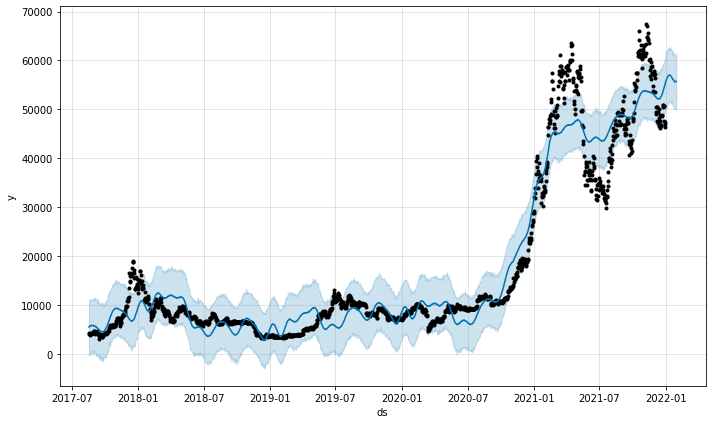

In [12]:
#Plotting the predicted values 
plot1 = model.plot(forecast)

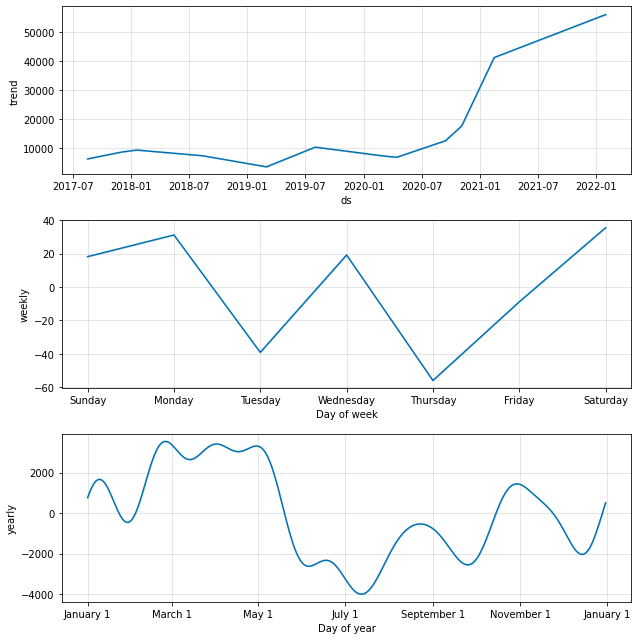

In [13]:
#Plotting the Forecasted components(Trend and Seasonality)
plt2 = model.plot_components(forecast)

# Hyperparameter Tuning

If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible:

In [14]:
changepoint_prior_scale = [0.001, 0.01, 0.1, 0.25, 0.30, 0.4, 0.5]
rmses = []

for x in changepoint_prior_scale:
  m = Prophet.Prophet(changepoint_prior_scale= x).fit(bc_date_close)
  df_cv = cross_validation(m, horizon='100 days', parallel="processes")
  df_p = performance_metrics(df_cv, rolling_window=1)
  rmses.append(df_p['rmse'].values[0])

rft = pd.DataFrame(list(zip(changepoint_prior_scale, rmses)), columns = ['changepoint_prior_scale', 'rmses'])
rft

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 23 forecasts with cutoffs between 2018-09-18 00:00:00 and 2021-09-22 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5b37b262d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 23 forecasts with cutoffs between 2018-09-18 00:00:00 and 2021-09-22 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5b37b81510>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 23 forecasts with cutoffs between 2018-09-18 00:00:00 and 2021-09-22 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5b3799f290>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_se

,changepoint_prior_scale,rmses
0,0.001,16435.629246
1,0.010,12465.387789
2,0.100,11452.662023
3,0.250,10752.700234
4,0.300,10888.411320
5,0.400,11021.941912
6,0.500,11008.619574


In [15]:
lowest_cps = rft['rmses'].min()
lowest_cps

10752.70023424164

In [16]:
best_rmses = rft.loc[rft['rmses'] == lowest_cps, 'changepoint_prior_scale']
best_rmses

3    0.25
Name: changepoint_prior_scale, dtype: float64

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


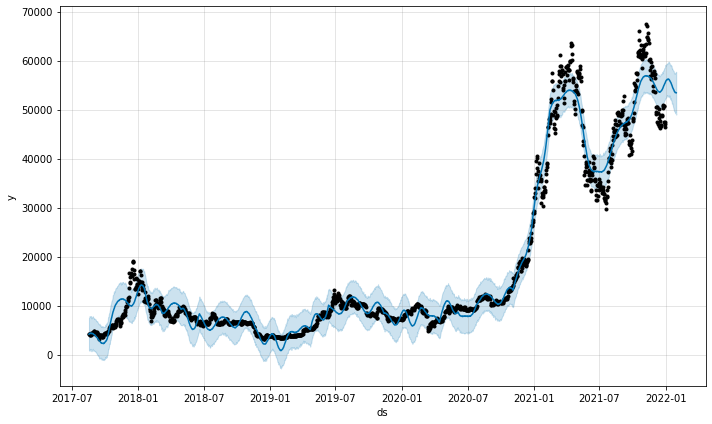

In [17]:
model_tuned = Prophet.Prophet(changepoint_prior_scale = best_rmses)
# fit the model on the entire dataset
model_tuned.fit(bc_date_close)

#Make a dataframe for future predictions and specify the capacity in the future. 
#Predict next 500 days after the final date of October 18, 2021
future = model.make_future_dataframe(periods=30,freq='D')
forecast = model_tuned.predict(future)

#Plotting the predicted values 
plot1 = model.plot(forecast)

# Forecasting Historical Data w/ Tuned Model

In [29]:
from datetime import datetime
from datetime import date, timedelta

In [30]:
#define the period for which we want a prediction
#prediction over last 7 days of the data collected
final_day = datetime.strptime(bc_date_close['ds'].max(), '%Y-%m-%d').date()
seven_day_past = final_day - timedelta(days=6)
past7 = list()

delta = timedelta(days=1)
while seven_day_past <= final_day:
    past7.append([seven_day_past])
    seven_day_past += delta
past7 = pd.DataFrame(past7)
past7.columns = ['ds']
past7['ds']= to_datetime(past7['ds'])

In [31]:
past7

,ds
0,2021-12-25
1,2021-12-26
2,2021-12-27
3,2021-12-28
4,2021-12-29
5,2021-12-30
6,2021-12-31


In [32]:
bc_dropped = bc_date_close.drop(bc_date_close.index[-7:-1])
bc_dropped = bc_dropped.drop(bc_dropped.index[-1])
bc_dropped

,ds,y
0,2017-08-17,4285.08
1,2017-08-18,4108.37
2,2017-08-19,4139.98
3,2017-08-20,4086.29
4,2017-08-21,4016.00
...,...,...
1586,2021-12-20,46914.16
1587,2021-12-21,48889.88
1588,2021-12-22,48588.16
1589,2021-12-23,50838.81


In [33]:
# use the model to make a forecast
t_model = Prophet.Prophet(changepoint_prior_scale = best_rmses)
t_model.fit(bc_dropped)
forecast1 = t_model.predict(past7)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


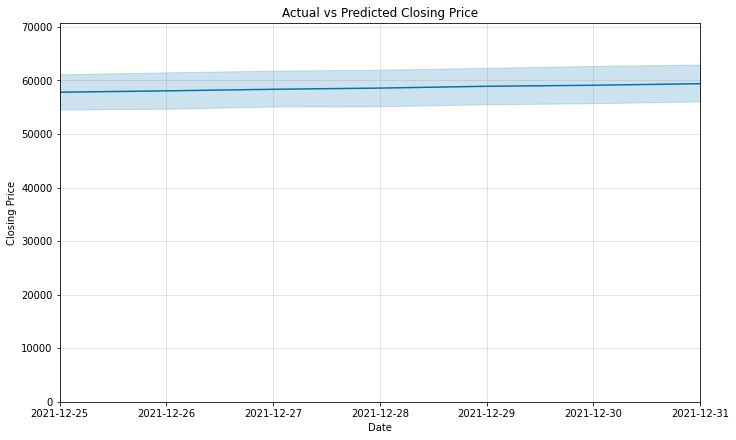

In [34]:
# plot forecast
t_model.plot(forecast1)
plt.xlim(past7.min(), past7.max())
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Price')
plt.show()

In [35]:
from sklearn.metrics import mean_absolute_error

In [36]:
# calculate MAE between expected and predicted values
y_true = bc_date_close['y'][-7:].values
y_pred = forecast1['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 9978.365


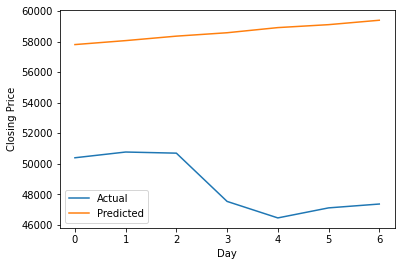

In [37]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [38]:
# summarize the forecast to compare values
bc_date_close['ds'] = pd.to_datetime(bc_date_close['ds'])
new = forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(bc_date_close)
new['Difference'] = new['y'] - new['yhat']
new

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,yhat,yhat_lower,yhat_upper,y,Difference
0,2021-12-25,57805.289180,54580.581183,61145.056988,50399.66,-7405.629180
1,2021-12-26,58064.710124,54712.433490,61520.148189,50775.49,-7289.220124
2,2021-12-27,58357.057812,55134.074510,61841.936165,50701.44,-7655.617812
3,2021-12-28,58579.591890,55173.250513,62017.760929,47543.74,-11035.851890
4,2021-12-29,58915.679742,55550.376209,62366.405814,46464.66,-12451.019742
5,2021-12-30,59108.356228,55752.047150,62720.272964,47120.87,-11987.486228
6,2021-12-31,59397.129010,56096.661442,62982.366388,47373.40,-12023.729010


# Forecasting Future Data w/ Tuned Model

In [ ]:
finalday_plus_one = pd.to_datetime(bc_date_close['ds'].max()) + timedelta(days=1)
finalday_plus_seven = finalday_plus_one + timedelta(days=6)
future7 = list()

delta = timedelta(days=1)
while finalday_plus_one <= finalday_plus_seven:
    future7.append([finalday_plus_one])
    finalday_plus_one += delta
future7 = pd.DataFrame(future7)
future7.columns = ['ds']
future7['ds']= to_datetime(future7['ds'])

In [ ]:
# use the model to make a forecast
forecast2 = t_model.predict(future7)
col1 = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
forecast2[col1]

,ds,yhat,yhat_lower,yhat_upper
0,2022-01-01,55780.762952,52276.684035,59044.162747
1,2022-01-02,55892.778385,52564.755186,59101.855891
2,2022-01-03,56016.949136,52777.450474,59315.530206
3,2022-01-04,56035.669956,52608.298766,59401.547050
4,2022-01-05,56159.517863,52775.901947,59487.026654
5,2022-01-06,56133.606862,52537.390791,59341.780798
6,2022-01-07,56200.797179,52903.598486,59619.842656


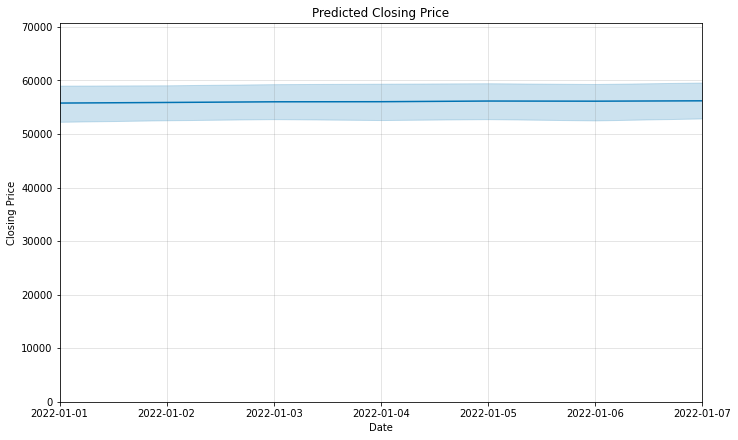

In [ ]:
# plot forecast
t_model.plot(forecast2)
plt.xlim(future7.min(), future7.max())
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Predicted Closing Price')
plt.show()

Real time series frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately.

Prophet Documentation:
https://facebook.github.io/prophet/docs/trend_changepoints.html#automatic-changepoint-detection-in-prophet

Text(0.5, 1.0, 'Changepoints')

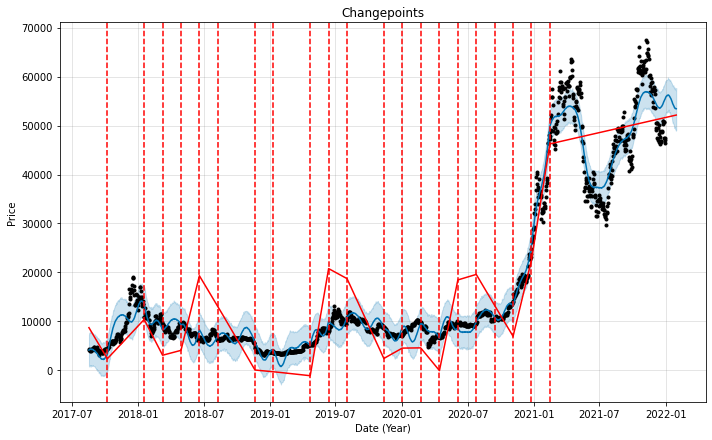

In [ ]:
fig = t_model.plot(forecast) #30 day prediction
a = add_changepoints_to_plot(fig.gca(), t_model, forecast)
plt.xlabel('Date (Year)')
plt.ylabel('Price')
plt.title('Changepoints')

In [ ]:
print(t_model.changepoints)

51     2017-10-07
102    2017-11-27
153    2018-01-17
204    2018-03-09
255    2018-04-29
306    2018-06-19
358    2018-08-10
409    2018-09-30
460    2018-11-20
511    2019-01-10
562    2019-03-02
613    2019-04-22
664    2019-06-12
715    2019-08-02
766    2019-09-22
817    2019-11-12
868    2020-01-02
919    2020-02-22
971    2020-04-14
1022   2020-06-04
1073   2020-07-25
1124   2020-09-14
1175   2020-11-04
1226   2020-12-25
1277   2021-02-14
Name: ds, dtype: datetime64[ns]


Dates above can be researched to see what outside sources may have caused the change

# Cross Validation

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point.

This cross validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period).

The output of cross_validation is a dataframe with the true values y and the out-of-sample forecast values yhat, at each simulated forecast date and for each cutoff date. In particular, a forecast is made for every observed point between cutoff and cutoff + horizon.

The initial model will be trained on the first 1,095 days of data. It will forecast the next 14 days of data. The model will then train on the initial period + the period (1,095 + 7 days in this case) and forecast the next 14 days. It will continued like this, adding another 7 days to the training data and then forecasting for the next 14 until there is no longer enough data to do this.

In [ ]:
#model is trained on the initial 1095 days, forecase the additional 7 days
df_cv = cross_validation(t_model, initial='1095 days', period='7 days', horizon = '14 days')
df_cv

INFO:prophet:Making 70 forecasts with cutoffs between 2020-08-21 00:00:00 and 2021-12-17 00:00:00


  0%|          | 0/70 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-08-22,11835.050688,10786.005433,12969.062001,11662.96,2020-08-21
1,2020-08-23,11835.643360,10767.813622,12879.327391,11648.13,2020-08-21
2,2020-08-24,11907.952089,10887.011725,12961.206606,11748.20,2020-08-21
3,2020-08-25,11903.383413,10850.586568,12972.742012,11318.42,2020-08-21
4,2020-08-26,11948.587446,10746.436519,12991.473702,11461.43,2020-08-21
...,...,...,...,...,...,...
975,2021-12-27,62730.149502,59265.391168,66034.729281,50701.44,2021-12-17
976,2021-12-28,62983.806264,59362.843798,66238.208345,47543.74,2021-12-17
977,2021-12-29,63355.250998,59779.768299,66580.780586,46464.66,2021-12-17
978,2021-12-30,63565.108980,60019.450994,67070.457600,47120.87,2021-12-17


The performance_metrics utility can be used to compute some useful statistics of the prediction performance (yhat, yhat_lower, and yhat_upper compared to y), as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), median absolute percent error (MDAPE) and coverage of the yhat_lower and yhat_upper estimates.

In [ ]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,2.778037e+07,5270.708981,3654.759623,0.092287,0.066515,0.090125,0.414286
1,3 days,2.951886e+07,5433.126062,3853.722810,0.096211,0.077192,0.094078,0.383673
2,4 days,3.088574e+07,5557.493619,4037.509113,0.101315,0.080766,0.099468,0.320408
3,5 days,3.604882e+07,6004.067168,4382.962370,0.109795,0.077123,0.107671,0.300000
4,6 days,3.908830e+07,6252.063909,4589.505914,0.115747,0.087560,0.113790,0.269388


Cross validation performance metrics can be visualized with plot_cross_validation_metric, here shown for MAPE. Dots show the absolute percent error for each prediction in df_cv. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots.

The MAPE (Mean Absolute Percent Error) measures the size of the error in percentage terms (easy interpretation). It is calculated as the average of the unsigned percentage error.

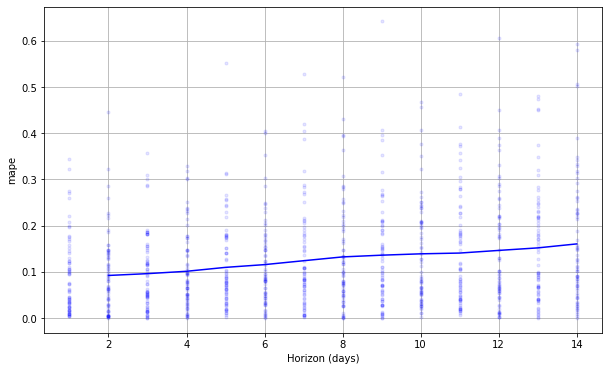

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

We see for this forecast that errors around 10% are typical for predictions two days into the future, and that errors increase up to around 17% for predictions that are a 14 days out.

The size of the rolling window can be changed with the optional argument rolling_window, which specifies the proportion of forecasts to use in each rolling window. The default is 0.1, corresponding to 10% of rows from df_cv included in each window; increasing this will lead to a smoother average curve in the figure. 

# Adding Regressors

In [ ]:
bc_prophet = bc[['Date','Close']]
bc_prophet.columns = ['ds', 'y']

In [ ]:
data_len = int(len(bc) - (len(bc) * .2))
data_len

1278

In [ ]:
bc_prophet['Open'] = bc['Open']
bc_prophet['High'] = bc['High']
bc_prophet['Low'] = bc['Low']
bc_prophet['Volume'] = bc['Volume']
bc_prophet['Return'] = bc['Return']
bc_prophet=bc_prophet.dropna()
train_X= bc_prophet[:data_len]
test_X= bc_prophet[data_len:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
pro_regressor= Prophet.Prophet(changepoint_prior_scale = best_rmses)
pro_regressor.add_regressor('Open')
pro_regressor.add_regressor('High')
pro_regressor.add_regressor('Low')
pro_regressor.add_regressor('Volume')
pro_regressor.add_regressor('Return')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


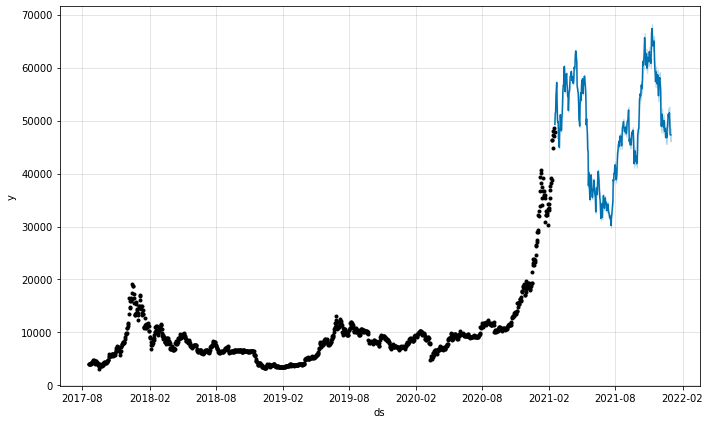

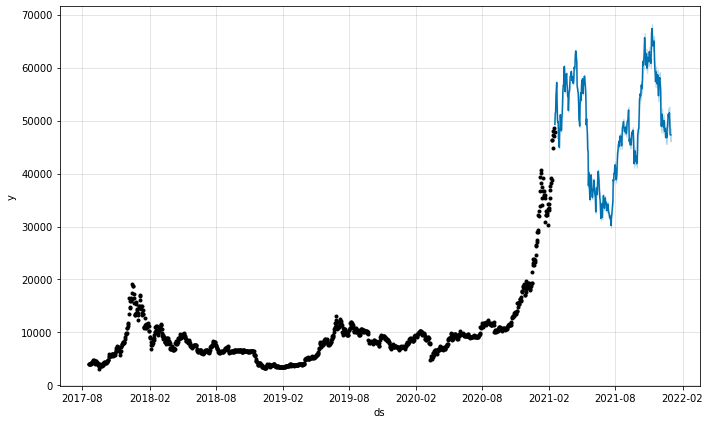

In [ ]:
pro_regressor.fit(train_X)
forecast_data = pro_regressor.predict(test_X)
pro_regressor.plot(forecast_data)

In [ ]:
y_true = bc_prophet['y'][-319:].values
y_pred = forecast_data['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 662.820


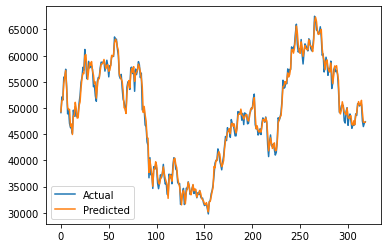

In [ ]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2021-02-16,49296.889200,49064.008269,49520.168299
1,2021-02-17,51411.745471,51170.476057,51633.671530
2,2021-02-18,51554.434315,51345.451984,51801.773302
3,2021-02-19,54684.690407,54451.611353,54906.187706
4,2021-02-20,55997.966858,55774.529930,56228.860977
...,...,...,...,...
314,2021-12-27,51470.703466,50271.677956,52674.879079
315,2021-12-28,49185.986080,47990.415875,50362.790037
316,2021-12-29,47296.402547,46056.034377,48576.786388
317,2021-12-30,47292.703248,46059.561211,48533.913928


In [ ]:
bc_prophet['ds'] = pd.to_datetime(bc_prophet['ds'])
new1 = forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(bc_prophet)
new1['Difference'] = new1['y'] - new1['yhat']
new1 = new1.drop(columns = ['Open', "High", 'Low', 'Volume', 'Return'])
new1.rename(columns={'ds':'Date', 'yhat': 'Prediction', 'yhat_lower':'Lower Prediction',
                     'yhat_upper': 'Upper Prediction', 'y': 'Actual'})

,Date,Prediction,Lower Prediction,Upper Prediction,Actual,Difference
0,2021-02-16,49296.889200,49064.008269,49520.168299,49133.45,-163.439200
1,2021-02-17,51411.745471,51170.476057,51633.671530,52119.71,707.964529
2,2021-02-18,51554.434315,51345.451984,51801.773302,51552.60,-1.834315
3,2021-02-19,54684.690407,54451.611353,54906.187706,55906.00,1221.309593
4,2021-02-20,55997.966858,55774.529930,56228.860977,55841.19,-156.776858
...,...,...,...,...,...,...
314,2021-12-27,51470.703466,50271.677956,52674.879079,50701.44,-769.263466
315,2021-12-28,49185.986080,47990.415875,50362.790037,47543.74,-1642.246080
316,2021-12-29,47296.402547,46056.034377,48576.786388,46464.66,-831.742547
317,2021-12-30,47292.703248,46059.561211,48533.913928,47120.87,-171.833248


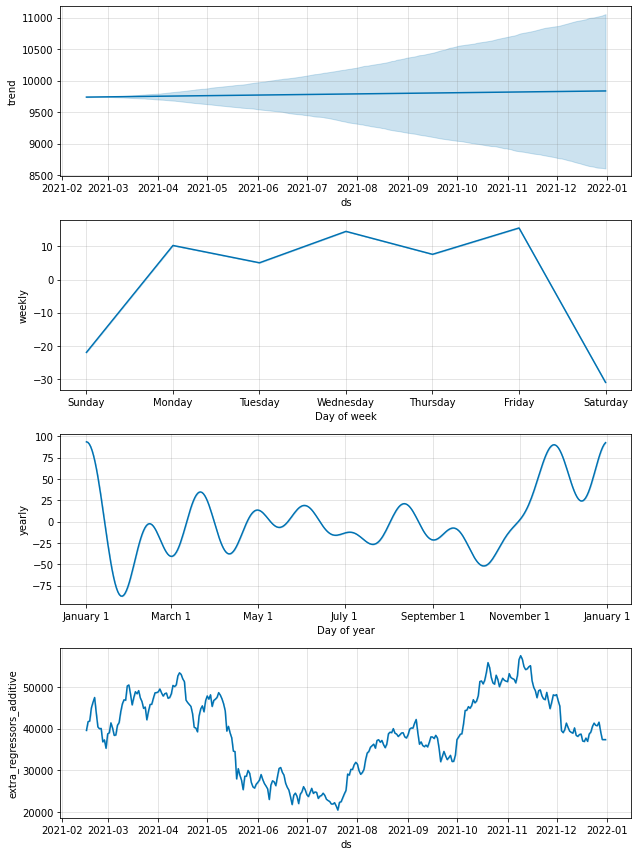

In [ ]:
fig = pro_regressor.plot_components(forecast_data)

In [ ]:
df_cv = cross_validation(t_model, initial='1095 days', period='7 days', horizon = '14 days')
pm = performance_metrics(df_cv)
display(pm.head(),pm.tail())

INFO:prophet:Making 70 forecasts with cutoffs between 2020-08-21 00:00:00 and 2021-12-17 00:00:00


  0%|          | 0/70 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,2.778037e+07,5270.708981,3654.759623,0.092287,0.066515,0.090125,0.426531
1,3 days,2.951886e+07,5433.126062,3853.722810,0.096211,0.077192,0.094078,0.383673
2,4 days,3.088574e+07,5557.493619,4037.509113,0.101315,0.080766,0.099468,0.320408
3,5 days,3.604882e+07,6004.067168,4382.962370,0.109795,0.077123,0.107671,0.310204
4,6 days,3.908830e+07,6252.063909,4589.505914,0.115747,0.087560,0.113790,0.273469


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
8,10 days,5.648174e+07,7515.433722,5542.659646,0.139108,0.110789,0.135932,0.236735
9,11 days,5.756083e+07,7586.885111,5584.428475,0.140774,0.107087,0.137662,0.248980
10,12 days,6.377240e+07,7985.762289,5822.924480,0.146485,0.101715,0.143315,0.267347
11,13 days,6.713313e+07,8193.480771,6027.462955,0.151961,0.107612,0.149556,0.261224
12,14 days,7.726251e+07,8789.909302,6408.318953,0.160588,0.101219,0.157824,0.226531


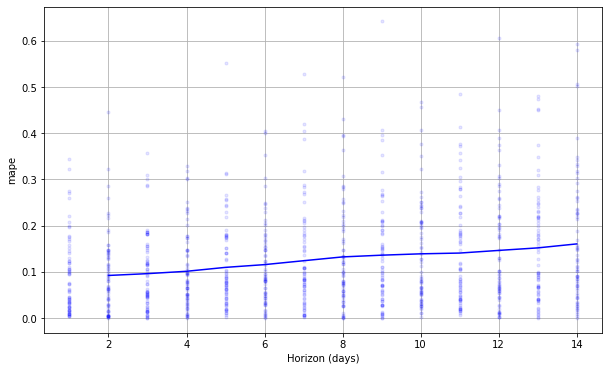

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()